With more than 1 million new diagnoses reported every year, prostate cancer (PCa) is the second most common cancer among males worldwide that results in more than 350,000 deaths annually. The key to decreasing mortality is developing more precise diagnostics. Diagnosis of PCa is based on the grading of prostate tissue biopsies. These tissue samples are examined by a pathologist and scored according to the Gleason grading system.

![](https://storage.googleapis.com/kaggle-media/competitions/PANDA/Screen%20Shot%202020-04-08%20at%202.03.53%20PM.png)

The following kernel uses a dataset of Prostate Tissue images and predicts the ISUP Grade of the PCa.
To sum it up, the clever ideas to look out for in the implementation -
1. EffecientNet Implementation
2. Tiling of the Images
3. Tiled Regularization
4. Learning Rate Scheduler

# Loading the Important Libraries

In [1]:
import os
import sys
import warnings
import random
import time

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import cv2
import skimage.io
from PIL import Image

from sklearn import metrics
from sklearn.model_selection import StratifiedKFold

from IPython.display import display
from tqdm import tqdm_notebook as tqdm

import torch
import albumentations
from albumentations.pytorch import ToTensorV2
from torch import nn, optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
pd.plotting.register_matplotlib_converters()
pd.options.display.max_rows=50
pd.options.display.max_columns=100
plt.rcParams.update({'font.size':18})
sns.set_style('darkgrid')
plt.rcParams.update({'font.family':'Humor Sans'})
plt.xkcd();

# Fixing Config

In [3]:
SEED = 68+1
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)
package_path = '../input/efficientnet-pytorch/EfficientNet-PyTorch/EfficientNet-PyTorch-master'
sys.path.append(package_path)
from efficientnet_pytorch import model as enet

Progress_Bar = False
DEBUG = False
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
data_dir = '../input/prostate-cancer-grade-assessment/'
train_img_dir = os.path.join(data_dir, 'train_images')
train_df = pd.read_csv(data_dir+'train.csv')
train_df = train_df.sample(1000).reset_index(drop=True) if DEBUG else train_df

display(train_df.head())
len(train_df)

,image_id,data_provider,isup_grade,gleason_score
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0


10616

# Create Folds

In [5]:
skf = StratifiedKFold(2, shuffle=True, random_state=SEED)
train_df['fold'] = -1
for i, (tr_idx, val_idx) in enumerate(skf.split(train_df, train_df['isup_grade'])):
    train_df.loc[val_idx, 'fold'] = i
train_df.head()

,image_id,data_provider,isup_grade,gleason_score,fold
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0,1
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0,1
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4,1
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4,0
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0,1


In [6]:
train_df.drop(columns=['data_provider', 'gleason_score'], inplace=True)
train_df.head()

,image_id,isup_grade,fold
0,0005f7aaab2800f6170c399693a96917,0,1
1,000920ad0b612851f8e01bcc880d9b3d,0,1
2,0018ae58b01bdadc8e347995b69f99aa,4,1
3,001c62abd11fa4b57bf7a6c603a11bb9,4,0
4,001d865e65ef5d2579c190a0e0350d8f,0,1


# Building Dataset

Because a majority of the image is "white space", passing the image directly to the network may result in the model not working upto its full potential as it tries to find patterns in the white space where there are none. So the image has been greedily tiled into 16 smaller images of regions where non-white pixels were more concentrated. 

To add a pre-model regularizing effect, each individual tile is flipped horizontally and vertically with a probability of 0.5 each and then the entire concatenated image is flipped with 0.5 probability too. The images are normalized using the Mean and Standard Deviation calculated on them previously.

In [7]:
class Build_Dataset(Dataset):
    '''Builds Dataset to be fed to Neural Network
       :param df: train_df or test_df
       :param resize: tuple, eg(256, 256)
       :param mode: string train or test 
       :param: augmentations: Image augmentations
    '''
    def __init__(self, df, mode='train', augmentations=None, sz=128, n_tiles=16):
        self.df = df
        self.mode = mode
        self.augmentations = augmentations
        self.N = n_tiles
        self.sz = sz
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        if self.mode == 'train':
            img_path = os.path.join(train_img_dir, self.df['image_id'].values[idx]) + '.tiff'
            image = skimage.io.MultiImage(img_path)[-1]
            label = self.df['isup_grade'].values[idx]
            
        if self.mode == 'test':
            img_path = os.path.join(test_img_dir, self.df['image_id'].values[idx]) + '.tiff'
            image = skimage.io.MultiImage(img_path)[-1]
            label = -1
        
        N = self.N
        sz = self.sz
        pad0, pad1 = (sz - image.shape[0]%sz)%sz, (sz - image.shape[1]%sz)%sz
        image = np.pad(image, [[pad0//2, pad0-pad0//2], [pad1//2, pad1-pad1//2], [0,0]], constant_values=255)
        image = image.reshape(image.shape[0]//sz, sz, image.shape[1]//sz, sz, 3)
        image = image.transpose(0,2,1,3,4).reshape(-1,sz,sz,3)
        if len(image)<N:
            image = np.pad(image, [[0,N-len(image)], [0,0], [0,0], [0,0]], constant_values=255)
        idxs = np.argsort(image.reshape(image.shape[0],-1).sum(-1))[:N]
        image = image[idxs]
            
        if self.mode == 'train':
            tile_augs = albumentations.Compose([
                albumentations.HorizontalFlip(p=0.5),
                albumentations.VerticalFlip(p=0.5),
            ])
            for i in range(16):
                aug = tile_augs(image = image[i])
                image[i] = aug['image']
            np.random.shuffle(image)
            
        image = cv2.vconcat([cv2.hconcat([image[0], image[1], image[2], image[3]]), 
                             cv2.hconcat([image[4], image[5], image[6], image[7]]), 
                             cv2.hconcat([image[8], image[9], image[10], image[11]]), 
                             cv2.hconcat([image[12], image[13], image[14], image[15]])])
            
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = np.array(image)
        
        if self.augmentations:
                augmented = self.augmentations(image=image)
                image = augmented['image']
        
        return image, label
     


# Plotting some Images

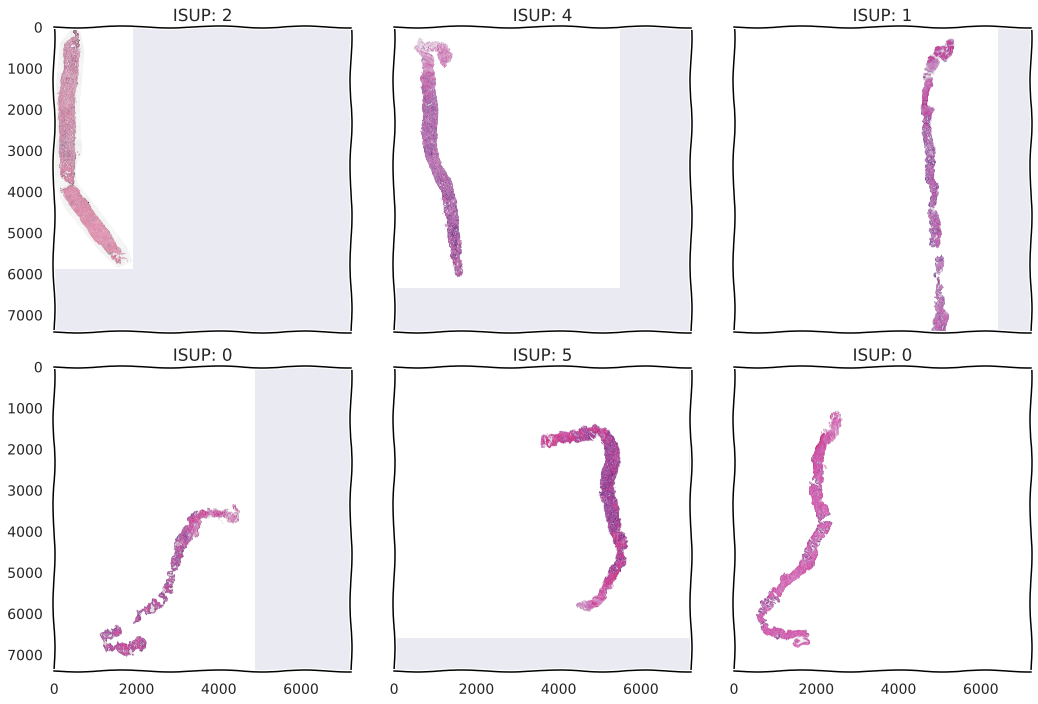

In [8]:
fig,axes=plt.subplots(ncols=3, nrows=2, figsize=(15,10), sharex=True, sharey=True)
for i in range(2):
    for j in range(3):
        ind = random.choice(range(9000))
        img_path = f'{train_img_dir}/{train_df.image_id[ind]}.tiff'
        img=skimage.io.MultiImage(img_path)[1]
        axes[i][j].imshow(img)
        axes[i][j].set_title(f'ISUP: {train_df.isup_grade[ind]}')

plt.tight_layout();

(512, 512, 3)
CPU times: user 608 ms, sys: 25.1 ms, total: 633 ms
Wall time: 712 ms


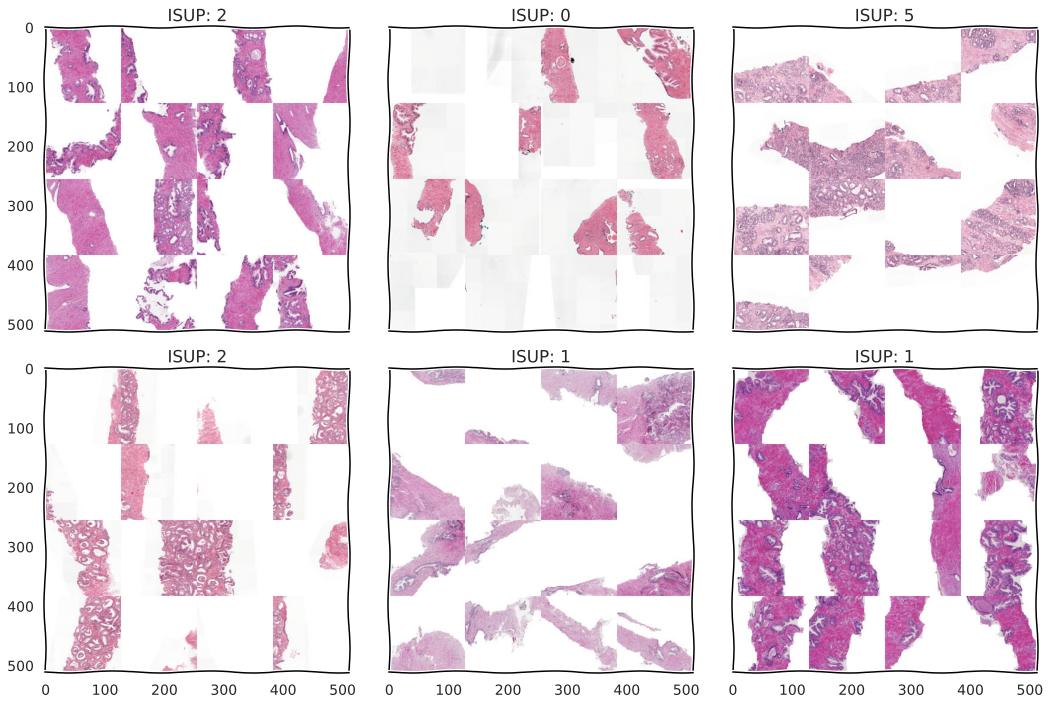

In [9]:
%%time

train_data = Build_Dataset(train_df, sz=128, mode='train')
image,label = train_data[101]
print(image.shape)

fig,axes=plt.subplots(ncols=3, nrows=2, figsize=(15,10), sharex=True, sharey=True)
for i in range(2):
    for j in range(3):
        img=train_data[random.choice(range(9000))]
        axes[i][j].imshow(img[0])
        axes[i][j].set_title(f'ISUP: {img[1]}')

plt.tight_layout();

As you see, a lot of white space still remains but that is necessary in order not to miss out actual data. 
Another point to notice is that, to the human eye the images are extremely indistinguishable and a very eduacted and experienced eye is required to actually grade the images. One can imagine that mistakes are very plausible in such scenarios and hence, perfecting automation of the detecting becomes not only a helping hand software but a necessity in the medical sector

# Processing The Images

In [10]:
#Image-net standard mean and std
# mean = [0.485, 0.456, 0.406]
# std = [0.229, 0.224, 0.225]

mean = [0.90949707, 0.8188697,  0.87795304]
std = [0.36357649, 0.49984502, 0.40477625]

#Defining train and test transforms
train_transforms = albumentations.Compose([
    albumentations.Normalize(mean=mean, std=std, always_apply=True),
    albumentations.HorizontalFlip(p=0.5),
    albumentations.VerticalFlip(p=0.5),
    albumentations.pytorch.ToTensorV2(),
])
test_transforms = albumentations.Compose([
    albumentations.Normalize(mean=mean, std=std, always_apply=True),
    albumentations.pytorch.ToTensorV2(),
])

# Building Model

In [11]:
pretrainied_model = {
    'efficientnet-b0': '../input/efficientnet-pytorch/efficientnet-b0-08094119.pth',
    'efficientnet-b1': '../input/efficientnet-pytorch/efficientnet-b1-dbc7070a.pth',
    'efficientnet-b2': '../input/efficientnet-pytorch/efficientnet-b2-27687264.pth',
    'efficientnet-b4': '../input/efficientnet-pytorch/efficientnet-b4-e116e8b3.pth'
}

class enetv2(nn.Module):
    def __init__(self, backbone, out_dim):
        super(enetv2, self).__init__()
        self.enet = enet.EfficientNet.from_name(backbone)
        self.enet.load_state_dict(torch.load(pretrainied_model[backbone]))
        self.myfc = nn.Linear(self.enet._fc.in_features, out_dim)
        self.enet._fc = nn.Identity()
    
    def extract(self, x):
        return self.enet(x)
    
    def forward(self, x):
        x = self.extract(x)
        x = self.myfc(x)
        return x

In [12]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [13]:
# model = enetv2('efficientnet-b0', 5).to(device)
# loss_criterion = nn.CrossEntropyLoss().to(device)
# optimizer=optim.Adam(model.parameters())

# print(f'The model has {count_parameters(model):,} trainable parameters')

# Defining Training and Validation epochs

In [14]:
def train(model, iterator, optimizer, criterion, device):
    
    epoch_loss = 0
    model.train()
    bar = tqdm(iterator) if Progress_Bar else iterator
    
    for (x, y) in bar:
        
        x = x.to(device, dtype=torch.float)
        y = y.to(device, dtype=torch.long)
        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        loss_np = loss.detach().cpu().numpy()
        epoch_loss += loss_np
        if Progress_Bar:
            bar.set_description('Training loss: %.5f' % (loss_np))
        
    return epoch_loss/len(iterator)

def evaluate(model, iterator, criterion, device):
    
    epoch_loss = 0
    preds = []
    preds = np.array(preds)
    targets = []
    targets = np.array(targets)
    model.eval()
    bar = tqdm(iterator) if Progress_Bar else iterator
    
    with torch.no_grad():
        
        for (x, y) in bar:
        
            x = x.to(device, dtype=torch.float)
            y = y.to(device, dtype=torch.long)
            y_pred = model(x)
            loss = criterion(y_pred, y)
            loss_np = loss.detach().cpu().numpy()
            epoch_loss += loss_np
            preds = np.append(preds, np.argmax(y_pred.detach().cpu().numpy(), axis = 1))
            targets = np.append(targets, y.detach().cpu().numpy())
#             preds = preds.reshape(-1)
#             targets = targets.reshape(-1)
            
            if Progress_Bar:
                bar.set_description('Validation loss: %.5f' % (loss_np))
            
    
            
    return epoch_loss/len(iterator), metrics.cohen_kappa_score(targets, preds, weights='quadratic')

# Defining Training Loop

In [15]:
def fit_model(model, model_name, train_iterator, valid_iterator, optimizer, scheduler, loss_criterion, device, epochs):
    """ Fits a dataset to model"""
    best_valid_loss = float('inf')
    
    train_losses = []
    valid_losses = []
    valid_metric_scores = []
    
    for epoch in range(epochs):
    
        start_time = time.time()
    
        train_loss = train(model, train_iterator, optimizer, loss_criterion, device)
        valid_loss, valid_metric_score = evaluate(model, valid_iterator, loss_criterion, device)
        scheduler.step(valid_loss)
        
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        valid_metric_scores.append(valid_metric_score)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), f'{model_name}.pt')
    
        end_time = time.time()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'Train Loss: {train_loss:.3f}')
        print(f'Val. Loss: {valid_loss:.3f} |  Val. Metric Score: {valid_metric_score:.3f}')
        print('-----------------------------------------------------------------------')
        
    return train_losses, valid_losses, valid_metric_scores
        
#     return pd.DataFrame({f'{model_name}_Training_Loss':train_losses, 
#                         f'{model_name}_Training_Acc':train_accs, 
#                         f'{model_name}_Validation_Loss':valid_losses, 
#                         f'{model_name}_Validation_Acc':valid_accs})

# Training with 5-Fold CV

In [16]:
tr_loss=[]
val_loss=[]
val_metric=[]

for fold in range(1):
    
    print(f"Fitting on Fold {fold+1}")
    #Make Train and Valid DataFrame from fold
    train_df_fold = train_df[train_df['fold'] != fold]
    valid_df_fold = train_df[train_df['fold'] == fold]
    
    #Build and load Dataset
    train_data = Build_Dataset(train_df_fold, mode='train', augmentations=train_transforms)
    valid_data = Build_Dataset(valid_df_fold, mode='train', augmentations=test_transforms)
    train_iterator = DataLoader(train_data, shuffle=True, batch_size=16, num_workers=4)
    valid_iterator = DataLoader(valid_data, batch_size=16, num_workers=4)
    
    #Initialize model, loss and optimizer
    model = enetv2('efficientnet-b2', out_dim=6).to(device)
    loss_criterion = nn.CrossEntropyLoss().to(device)
    opt1 = optim.Adam(model.parameters(), lr=1e-3, betas=(0.9,0.999))
    scheduler = lr_scheduler.ReduceLROnPlateau(opt1, mode='min', factor=0.9, patience=1, verbose=True)

    temp_tr_loss, temp_val_loss, temp_val_metric = fit_model(model, 'efficientnet-b2', train_iterator, valid_iterator, opt1, scheduler, loss_criterion, device, epochs=3)
    
    tr_loss+=temp_tr_loss
    val_loss+=temp_val_loss
    val_metric+=temp_val_metric
    


Fitting on Fold 1
Epoch: 01 | Epoch Time: 6m 9s
Train Loss: 1.388
Val. Loss: 1.951 |  Val. Metric Score: 0.377
-----------------------------------------------------------------------
Epoch: 02 | Epoch Time: 6m 5s
Train Loss: 1.230
Val. Loss: 1.261 |  Val. Metric Score: 0.686
-----------------------------------------------------------------------
Epoch: 03 | Epoch Time: 6m 5s
Train Loss: 1.174
Val. Loss: 1.178 |  Val. Metric Score: 0.710
-----------------------------------------------------------------------


In [17]:
opt2 = optim.Adam(model.parameters(), lr=1e-4, betas=(0.9, 0.999))
scheduler = lr_scheduler.ReduceLROnPlateau(opt2, mode='min', factor=0.9, patience=1, verbose=True)
temp_tr_loss, temp_val_loss, temp_val_metric = fit_model(model, 'efficientnet-b2', train_iterator, valid_iterator, opt2,scheduler, loss_criterion, device, epochs=7)

tr_loss+=temp_tr_loss
val_loss+=temp_val_loss
val_metric+=temp_val_metric

Epoch: 01 | Epoch Time: 6m 6s
Train Loss: 1.032
Val. Loss: 1.023 |  Val. Metric Score: 0.751
-----------------------------------------------------------------------
Epoch: 02 | Epoch Time: 6m 8s
Train Loss: 0.969
Val. Loss: 1.009 |  Val. Metric Score: 0.752
-----------------------------------------------------------------------
Epoch: 03 | Epoch Time: 6m 8s
Train Loss: 0.941
Val. Loss: 1.007 |  Val. Metric Score: 0.764
-----------------------------------------------------------------------
Epoch: 04 | Epoch Time: 6m 8s
Train Loss: 0.902
Val. Loss: 1.000 |  Val. Metric Score: 0.770
-----------------------------------------------------------------------
Epoch: 05 | Epoch Time: 6m 7s
Train Loss: 0.882
Val. Loss: 1.008 |  Val. Metric Score: 0.755
-----------------------------------------------------------------------
Epoch     6: reducing learning rate of group 0 to 9.0000e-05.
Epoch: 06 | Epoch Time: 6m 10s
Train Loss: 0.836
Val. Loss: 1.020 |  Val. Metric Score: 0.763
-------------------

In [18]:
opt3 = optim.Adam(model.parameters(), lr=1e-5, betas=(0.9, 0.999))
scheduler = lr_scheduler.ReduceLROnPlateau(opt3, mode='min', factor=0.9, patience=1, verbose=True)
temp_tr_loss, temp_val_loss, temp_val_metric = fit_model(model, 'efficientnet-b2', train_iterator, valid_iterator, opt2,scheduler, loss_criterion, device, epochs=3)

tr_loss+=temp_tr_loss
val_loss+=temp_val_loss
val_metric+=temp_val_metric

Epoch: 01 | Epoch Time: 6m 9s
Train Loss: 0.759
Val. Loss: 1.030 |  Val. Metric Score: 0.761
-----------------------------------------------------------------------
Epoch: 02 | Epoch Time: 6m 8s
Train Loss: 0.718
Val. Loss: 1.085 |  Val. Metric Score: 0.770
-----------------------------------------------------------------------
Epoch     3: reducing learning rate of group 0 to 9.0000e-06.
Epoch: 03 | Epoch Time: 6m 9s
Train Loss: 0.698
Val. Loss: 1.066 |  Val. Metric Score: 0.773
-----------------------------------------------------------------------


In [19]:
# opt4 = optim.Adam(model.parameters(), lr=0.3 * 1e-5, betas=(0.9, 0.99))
# temp_tr_loss, temp_val_loss, temp_val_metric = fit_model(model, 'efficientnet-b2', train_iterator, valid_iterator, opt4, loss_criterion, device, epochs=2)

# tr_loss+=temp_tr_loss
# val_loss+=temp_val_loss
# val_metric+=temp_val_metric

# **Plotting the Losses and the Metric**

In [20]:
len(tr_loss)

13

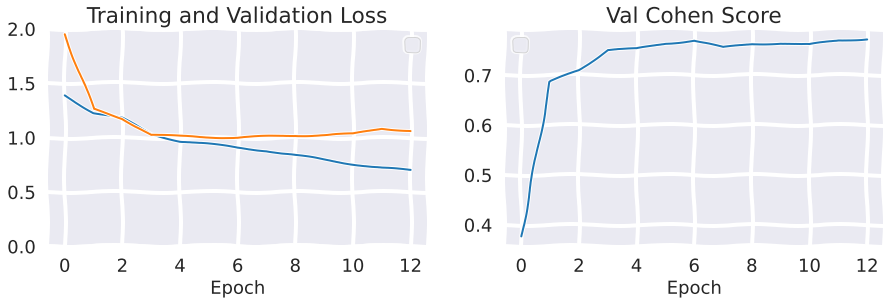

In [21]:
plt.rcParams.update({'font.size':18})
sns.set_style('darkgrid')
plt.rcParams.update({'font.family':'Humor-Sans'})

fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
ax[0].plot(tr_loss)
ax[0].set_title('Training and Validation Loss')
ax[0].plot(val_loss)
ax[0].set_ylim((0,2))
ax[0].set_xlabel('Epoch')

ax[1].plot(val_metric)
ax[1].set_title('Val Cohen Score')
ax[1].set_xlabel('Epoch')


ax[0].legend();
ax[1].legend();

In [22]:
%%time
torch.save(model.state_dict(), f'enetb2-trained.pt')

CPU times: user 33.3 ms, sys: 31.3 ms, total: 64.7 ms
Wall time: 64.4 ms


# Making submission to leaderboard

In [23]:
def get_predictions(model, iterator, device):
    
    preds = []
    model.eval()
    bar = tqdm(iterator) if Progress_Bar else iterator
    
    with torch.no_grad():
        
        for (x, y) in bar:
        
            x = x.to(device, dtype=torch.float)
            y = y.to(device, dtype=torch.long)
            y_pred = model(x)
            preds.append(np.argmax(y_pred.detach().cpu().numpy(), axis = 1))
            
    preds = np.array(preds)
    preds = preds.reshape(-1)
            
    return preds

In [24]:
test_df = pd.read_csv(data_dir+'test.csv')
sample = pd.read_csv('../input/prostate-cancer-grade-assessment/sample_submission.csv')
test_df.drop(columns=['data_provider'], inplace=True)
test_img_dir = '../input/prostate-cancer-grade-assessment/test_images'
    
# #Build and load Test Data
# test_data = Build_Dataset(test_df, resize=(256, 256), mode='test', augmentations=test_transforms)
# test_iterator = DataLoader(test_data, batch_size=2, num_workers=4)
    
# #Get predictions
# y_pred = get_predictions(model, test_iterator, device)
    
# #Submit Predictions
# test_df['isup_grade'] = y_pred
# test_df.to_csv('submission.csv', index=False)

In [25]:
def submit(sample):
    if os.path.exists('../input/prostate-cancer-grade-assessment/test_images'):
        test_data = Build_Dataset(test_df, resize=(256, 256), mode='test', augmentations=test_transforms)
        test_iterator = DataLoader(test_data, batch_size=2, num_workers=4)
        preds = get_predictions(model, test_iterator, device)
        sample['isup_grade'] = preds
    return sample

In [26]:
submission = submit(sample)
submission['isup_grade'] = submission['isup_grade'].astype(int)
submission.head()

,image_id,isup_grade
0,005700be7e06878e6605e7a5a39de1b2,0
1,005c6e8877caf724c600fdce5d417d40,0
2,0104f76634ff89bfff1ef0804a95c380,0


In [27]:
submission.to_csv('submission.csv', index=False)